In [21]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import optuna.integration.lightgbm as lgb
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [23]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [24]:
data_dir = Path('../input')
feature_dir = Path('../feature')
val_dir = Path('../txt')
tst_dir = Path('../txt')
sub_dir = Path('../submission')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [25]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [26]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 26)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,g_r,u_g,r_i,i_z,u_r,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ur,d_dered_ri,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.3723,1.1898,0.0,1.3273,2.9272,1.3371,0.7328,4.2545,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,2.8665,1.3027,0.7232,4.1691,1.3230,2.1456
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.5266,1.2533,1.0,0.6096,0.9902,0.1840,0.0995,1.5997,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,0.9619,0.5931,0.1016,1.5550,0.1751,1.3163
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,0.7413,1.0225,0.0,0.2891,0.9610,0.1428,0.0435,1.2501,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,0.9211,0.2466,0.0257,1.1676,0.1183,1.4821
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,0.9591,1.2054,0.0,0.9676,4.4719,0.3262,0.2603,5.4395,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,4.3590,0.9074,0.2395,5.2664,0.2926,1.4454
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.2917,1.1939,0.0,1.6568,3.7543,0.7182,0.3415,5.4111,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,3.3376,1.5709,0.3144,4.9084,0.6727,1.9857


In [27]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 25) (80000, 25)


In [28]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [29]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "n_estimators": 1000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [30]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], 
                  verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), 
                       axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-06 15:24:45,747] A new study created in memory with name: no-name-9b105626-6230-4c48-b7ef-8a1cc429ec6c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.148563	valid_1's multi_logloss: 0.161707


feature_fraction, val_score: 0.161707:  14%|#4        | 1/7 [00:20<02:04, 20.82s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.143883	valid_1's multi_logloss: 0.160292
[200]	training's multi_logloss: 0.131677	valid_1's multi_logloss: 0.158459
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.125949	valid_1's multi_logloss: 0.15809


feature_fraction, val_score: 0.158090:  29%|##8       | 2/7 [01:14<02:33, 30.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.145734	valid_1's multi_logloss: 0.160264
[200]	training's multi_logloss: 0.132933	valid_1's multi_logloss: 0.157908
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.129646	valid_1's multi_logloss: 0.157713


feature_fraction, val_score: 0.157713:  43%|####2     | 3/7 [02:18<02:42, 40.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.14464	valid_1's multi_logloss: 0.160185
[200]	training's multi_logloss: 0.132013	valid_1's multi_logloss: 0.158034
Early stopping, best iteration is:
[233]	training's multi_logloss: 0.128836	valid_1's multi_logloss: 0.157819


feature_fraction, val_score: 0.157713:  57%|#####7    | 4/7 [03:04<02:07, 42.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.146185	valid_1's multi_logloss: 0.160497
Early stopping, best iteration is:
[107]	training's multi_logloss: 0.144981	valid_1's multi_logloss: 0.160335


feature_fraction, val_score: 0.157713:  71%|#######1  | 5/7 [03:26<01:12, 36.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.148933	valid_1's multi_logloss: 0.162193
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.138531	valid_1's multi_logloss: 0.158955


feature_fraction, val_score: 0.157713:  86%|########5 | 6/7 [03:58<00:34, 34.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.147683	valid_1's multi_logloss: 0.161202


num_leaves, val_score: 0.157713:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.101367	valid_1's multi_logloss: 0.156968
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.101049	valid_1's multi_logloss: 0.156935


num_leaves, val_score: 0.156935:   5%|5         | 1/20 [00:31<10:01, 31.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.13185	valid_1's multi_logloss: 0.158165
Early stopping, best iteration is:
[182]	training's multi_logloss: 0.116482	valid_1's multi_logloss: 0.157134


num_leaves, val_score: 0.156935:  10%|#         | 2/20 [01:12<10:18, 34.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.091673	valid_1's multi_logloss: 0.156847
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0904789	valid_1's multi_logloss: 0.156804


num_leaves, val_score: 0.156804:  15%|#5        | 3/20 [01:46<09:45, 34.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0882276	valid_1's multi_logloss: 0.157267
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.091585	valid_1's multi_logloss: 0.15717


num_leaves, val_score: 0.156804:  20%|##        | 4/20 [02:22<09:17, 34.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0945333	valid_1's multi_logloss: 0.157339
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.0910041	valid_1's multi_logloss: 0.157256


num_leaves, val_score: 0.156804:  25%|##5       | 5/20 [03:12<09:51, 39.45s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.106282	valid_1's multi_logloss: 0.157343
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.104623	valid_1's multi_logloss: 0.157278


num_leaves, val_score: 0.156804:  30%|###       | 6/20 [03:43<08:34, 36.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.100383	valid_1's multi_logloss: 0.157001
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.100049	valid_1's multi_logloss: 0.156961


num_leaves, val_score: 0.156804:  35%|###5      | 7/20 [04:17<07:47, 36.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0894568	valid_1's multi_logloss: 0.157168
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0890386	valid_1's multi_logloss: 0.15715


num_leaves, val_score: 0.156804:  40%|####      | 8/20 [04:51<07:03, 35.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.117672	valid_1's multi_logloss: 0.157241
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.111457	valid_1's multi_logloss: 0.156993


num_leaves, val_score: 0.156804:  45%|####5     | 9/20 [05:24<06:20, 34.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0995927	valid_1's multi_logloss: 0.157173
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.0960569	valid_1's multi_logloss: 0.157145


num_leaves, val_score: 0.156804:  50%|#####     | 10/20 [05:56<05:39, 33.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.112442	valid_1's multi_logloss: 0.157138
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.110066	valid_1's multi_logloss: 0.157016


num_leaves, val_score: 0.156804:  55%|#####5    | 11/20 [06:26<04:53, 32.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0952246	valid_1's multi_logloss: 0.157052
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0942304	valid_1's multi_logloss: 0.156988


num_leaves, val_score: 0.156804:  60%|######    | 12/20 [06:58<04:19, 32.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0881386	valid_1's multi_logloss: 0.157268
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.0919224	valid_1's multi_logloss: 0.157208


num_leaves, val_score: 0.156804:  65%|######5   | 13/20 [07:30<03:47, 32.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.106282	valid_1's multi_logloss: 0.157343
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.104623	valid_1's multi_logloss: 0.157278


num_leaves, val_score: 0.156804:  70%|#######   | 14/20 [08:03<03:16, 32.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.101891	valid_1's multi_logloss: 0.157109
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.100361	valid_1's multi_logloss: 0.157087


num_leaves, val_score: 0.156804:  75%|#######5  | 15/20 [08:40<02:49, 33.94s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0961535	valid_1's multi_logloss: 0.157202
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0989763	valid_1's multi_logloss: 0.157168


num_leaves, val_score: 0.156804:  80%|########  | 16/20 [09:20<02:22, 35.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.103018	valid_1's multi_logloss: 0.157055
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.104372	valid_1's multi_logloss: 0.157046


num_leaves, val_score: 0.156804:  85%|########5 | 17/20 [09:52<01:43, 34.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0972762	valid_1's multi_logloss: 0.157356


num_leaves, val_score: 0.156804:  90%|######### | 18/20 [10:26<01:09, 34.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115825	valid_1's multi_logloss: 0.157226
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.112565	valid_1's multi_logloss: 0.157097


num_leaves, val_score: 0.156804:  95%|#########5| 19/20 [11:08<00:36, 36.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.214287	valid_1's multi_logloss: 0.215521
[200]	training's multi_logloss: 0.202271	valid_1's multi_logloss: 0.204313
[300]	training's multi_logloss: 0.19733	valid_1's multi_logloss: 0.199804
[400]	training's multi_logloss: 0.194366	valid_1's multi_logloss: 0.197111
[500]	training's multi_logloss: 0.192391	valid_1's multi_logloss: 0.195315
[600]	training's multi_logloss: 0.190995	valid_1's multi_logloss: 0.194063
[700]	training's multi_logloss: 0.1

bagging, val_score: 0.156804:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0897603	valid_1's multi_logloss: 0.158597
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.092583	valid_1's multi_logloss: 0.158581


bagging, val_score: 0.156804:  10%|#         | 1/10 [00:37<05:36, 37.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0915338	valid_1's multi_logloss: 0.1569
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.0928843	valid_1's multi_logloss: 0.156884


bagging, val_score: 0.156804:  20%|##        | 2/10 [01:16<05:02, 37.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0911914	valid_1's multi_logloss: 0.157413
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0911914	valid_1's multi_logloss: 0.157413


bagging, val_score: 0.156804:  30%|###       | 3/10 [02:05<04:49, 41.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0913625	valid_1's multi_logloss: 0.157107
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0902049	valid_1's multi_logloss: 0.157084


bagging, val_score: 0.156804:  40%|####      | 4/10 [02:47<04:07, 41.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.099448	valid_1's multi_logloss: 0.160786


bagging, val_score: 0.156804:  50%|#####     | 5/10 [03:26<03:23, 40.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.090329	valid_1's multi_logloss: 0.157518
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0940053	valid_1's multi_logloss: 0.157379


bagging, val_score: 0.156804:  60%|######    | 6/10 [04:03<02:38, 39.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0951603	valid_1's multi_logloss: 0.157553


bagging, val_score: 0.156804:  70%|#######   | 7/10 [04:34<01:51, 37.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0991076	valid_1's multi_logloss: 0.159315


bagging, val_score: 0.156804:  80%|########  | 8/10 [05:11<01:14, 37.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0909926	valid_1's multi_logloss: 0.157464
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.0948525	valid_1's multi_logloss: 0.157417


bagging, val_score: 0.156804:  90%|######### | 9/10 [05:58<00:39, 39.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.100256	valid_1's multi_logloss: 0.160526


feature_fraction_stage2, val_score: 0.156804:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


feature_fraction_stage2, val_score: 0.156658:  17%|#6        | 1/6 [00:27<02:19, 27.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.091673	valid_1's multi_logloss: 0.156847
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0904789	valid_1's multi_logloss: 0.156804


feature_fraction_stage2, val_score: 0.156658:  33%|###3      | 2/6 [00:54<01:50, 27.58s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0909994	valid_1's multi_logloss: 0.157037
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0889755	valid_1's multi_logloss: 0.156981


feature_fraction_stage2, val_score: 0.156658:  50%|#####     | 3/6 [01:23<01:23, 27.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0923607	valid_1's multi_logloss: 0.157151
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0923607	valid_1's multi_logloss: 0.157151


feature_fraction_stage2, val_score: 0.156658:  67%|######6   | 4/6 [01:49<00:54, 27.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0920963	valid_1's multi_logloss: 0.156964
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0905273	valid_1's multi_logloss: 0.156938


feature_fraction_stage2, val_score: 0.156658:  83%|########3 | 5/6 [02:19<00:28, 28.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.091673	valid_1's multi_logloss: 0.156847
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0904789	valid_1's multi_logloss: 0.156804


regularization_factors, val_score: 0.156658:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906069	valid_1's multi_logloss: 0.156627
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0915183	valid_1's multi_logloss: 0.156535


regularization_factors, val_score: 0.156535:   5%|5         | 1/20 [00:33<10:28, 33.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906274	valid_1's multi_logloss: 0.156859
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0935601	valid_1's multi_logloss: 0.156763


regularization_factors, val_score: 0.156535:  10%|#         | 2/20 [01:04<09:47, 32.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906275	valid_1's multi_logloss: 0.156859
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0935602	valid_1's multi_logloss: 0.156763


regularization_factors, val_score: 0.156535:  15%|#5        | 3/20 [01:37<09:16, 32.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906275	valid_1's multi_logloss: 0.156859
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0935602	valid_1's multi_logloss: 0.156763


regularization_factors, val_score: 0.156535:  20%|##        | 4/20 [02:10<08:43, 32.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0903162	valid_1's multi_logloss: 0.157052
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0911304	valid_1's multi_logloss: 0.156987


regularization_factors, val_score: 0.156535:  25%|##5       | 5/20 [02:42<08:07, 32.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906276	valid_1's multi_logloss: 0.156859
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0935602	valid_1's multi_logloss: 0.156763


regularization_factors, val_score: 0.156535:  30%|###       | 6/20 [03:12<07:26, 31.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906275	valid_1's multi_logloss: 0.156859
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0935602	valid_1's multi_logloss: 0.156763


regularization_factors, val_score: 0.156535:  35%|###5      | 7/20 [03:46<07:02, 32.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906274	valid_1's multi_logloss: 0.156859
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0935601	valid_1's multi_logloss: 0.156763


regularization_factors, val_score: 0.156535:  40%|####      | 8/20 [04:22<06:41, 33.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906068	valid_1's multi_logloss: 0.156627
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0915182	valid_1's multi_logloss: 0.156535


regularization_factors, val_score: 0.156535:  45%|####5     | 9/20 [04:53<06:01, 32.84s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0906068	valid_1's multi_logloss: 0.156627
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0915182	valid_1's multi_logloss: 0.156535


regularization_factors, val_score: 0.156535:  50%|#####     | 10/20 [05:31<05:42, 34.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's multi_logloss: 0.0905884	valid_1's multi_logloss: 0.157143
[LightGBM] [Warning] No further s

regularization_factors, val_score: 0.156535:  55%|#####5    | 11/20 [06:13<05:28, 36.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:

regularization_factors, val_score: 0.156535:  60%|######    | 12/20 [06:52<04:58, 37.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0970747	valid_1's multi_logloss: 0.157423


regularization_factors, val_score: 0.156535:  65%|######5   | 13/20 [07:24<04:09, 35.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


regularization_factors, val_score: 0.156535:  70%|#######   | 14/20 [07:53<03:23, 33.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


regularization_factors, val_score: 0.156535:  75%|#######5  | 15/20 [08:24<02:44, 32.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


regularization_factors, val_score: 0.156535:  80%|########  | 16/20 [08:54<02:08, 32.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156657


regularization_factors, val_score: 0.156535:  85%|########5 | 17/20 [09:24<01:34, 31.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


regularization_factors, val_score: 0.156535:  90%|######### | 18/20 [09:57<01:04, 32.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


regularization_factors, val_score: 0.156535:  95%|#########5| 19/20 [10:27<00:31, 31.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0907285	valid_1's multi_logloss: 0.156706
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0914043	valid_1's multi_logloss: 0.156658


min_data_in_leaf, val_score: 0.156535:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.156535:  20%|##        | 1/5 [00:31<02:06, 31.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0887112	valid_1's multi_logloss: 0.157051
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.0879648	valid_1's multi_logloss: 0.157047


min_data_in_leaf, val_score: 0.156535:  40%|####      | 2/5 [01:02<01:33, 31.32s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0914125	valid_1's multi_logloss: 0.156809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.0927623	valid_1's multi_logloss: 0.156766


min_data_in_leaf, val_score: 0.156535:  60%|######    | 3/5 [01:33<01:02, 31.22s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.156535:  80%|########  | 4/5 [02:04<00:31, 31.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6060
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 25
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.0875395	valid_1's multi_logloss: 0.157565
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.090745	valid_1's multi_logloss: 0.157452


min_data_in_leaf, val_score: 0.156535: 100%|##########| 5/5 [02:31<00:00, 30.31s/it]


Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'lambda_l1': 7.700053421427285e-06, 'lambda_l2': 5.626169212347464e-05, 'random_state': 42, 'n_jobs': -1, 'feature_pre_filter': False, 'bagging_freq': 1, 'num_leaves': 237, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 1.0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 10}
  Accuracy = 0.9345625
  Params: 
    objective: multiclass
    metric: multi_logloss
    num_class: 3
    lambda_l1: 7.700053421427285e-06
    lambda_l2: 5.626169212347464e-05
    random_state: 42
    n_jobs: -1
    feature_pre_filter: False
    bagging_freq: 1
    num_leaves: 237
    feature_fraction: 0.6799999999999999
    bagging_fraction: 1.0
    min_child_samples: 20
    num_iterations: 1000
    early_stopping_round: 10


In [31]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [32]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[LightGBM] [Warning] feature_fraction is set=0.6799999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6799999999999999
[LightGBM] [Warning] lambda_l1 is set=7.700053421427285e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.700053421427285e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.626169212347464e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.626169212347464e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 0.848654
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.741361
[3]	valid_0's multi_logloss: 0.656453
[4]	valid_0's multi_logloss: 0.582812
[5]	valid_0's multi_logloss: 0.524435
[6]	valid_0's multi_logloss: 0.474217
[7]	valid_0's multi_logloss:

[76]	valid_0's multi_logloss: 0.156354
[77]	valid_0's multi_logloss: 0.156281
[78]	valid_0's multi_logloss: 0.156259
[79]	valid_0's multi_logloss: 0.156205
[80]	valid_0's multi_logloss: 0.156167
[81]	valid_0's multi_logloss: 0.156111
[82]	valid_0's multi_logloss: 0.156091
[83]	valid_0's multi_logloss: 0.156088
[84]	valid_0's multi_logloss: 0.156066
[85]	valid_0's multi_logloss: 0.156012
[86]	valid_0's multi_logloss: 0.156015
[87]	valid_0's multi_logloss: 0.155987
[88]	valid_0's multi_logloss: 0.155972
[89]	valid_0's multi_logloss: 0.155977
[90]	valid_0's multi_logloss: 0.155979
[91]	valid_0's multi_logloss: 0.155972
[92]	valid_0's multi_logloss: 0.155995
[93]	valid_0's multi_logloss: 0.156002
[94]	valid_0's multi_logloss: 0.156034
[95]	valid_0's multi_logloss: 0.156065
[96]	valid_0's multi_logloss: 0.156053
[97]	valid_0's multi_logloss: 0.156039
[98]	valid_0's multi_logloss: 0.156046
[99]	valid_0's multi_logloss: 0.156043
[100]	valid_0's multi_logloss: 0.156049
[101]	valid_0's multi_lo

[50]	valid_0's multi_logloss: 0.161457
[51]	valid_0's multi_logloss: 0.161228
[52]	valid_0's multi_logloss: 0.160937
[53]	valid_0's multi_logloss: 0.160713
[54]	valid_0's multi_logloss: 0.160475
[55]	valid_0's multi_logloss: 0.160047
[56]	valid_0's multi_logloss: 0.159725
[57]	valid_0's multi_logloss: 0.159396
[58]	valid_0's multi_logloss: 0.159053
[59]	valid_0's multi_logloss: 0.158794
[60]	valid_0's multi_logloss: 0.158508
[61]	valid_0's multi_logloss: 0.158241
[62]	valid_0's multi_logloss: 0.158073
[63]	valid_0's multi_logloss: 0.157894
[64]	valid_0's multi_logloss: 0.157687
[65]	valid_0's multi_logloss: 0.157562
[66]	valid_0's multi_logloss: 0.157347
[67]	valid_0's multi_logloss: 0.157149
[68]	valid_0's multi_logloss: 0.157094
[69]	valid_0's multi_logloss: 0.157026
[70]	valid_0's multi_logloss: 0.156964
[71]	valid_0's multi_logloss: 0.156834
[72]	valid_0's multi_logloss: 0.156734
[73]	valid_0's multi_logloss: 0.156646
[74]	valid_0's multi_logloss: 0.156494
[75]	valid_0's multi_logl

In [33]:

print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.4678%


In [34]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [35]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

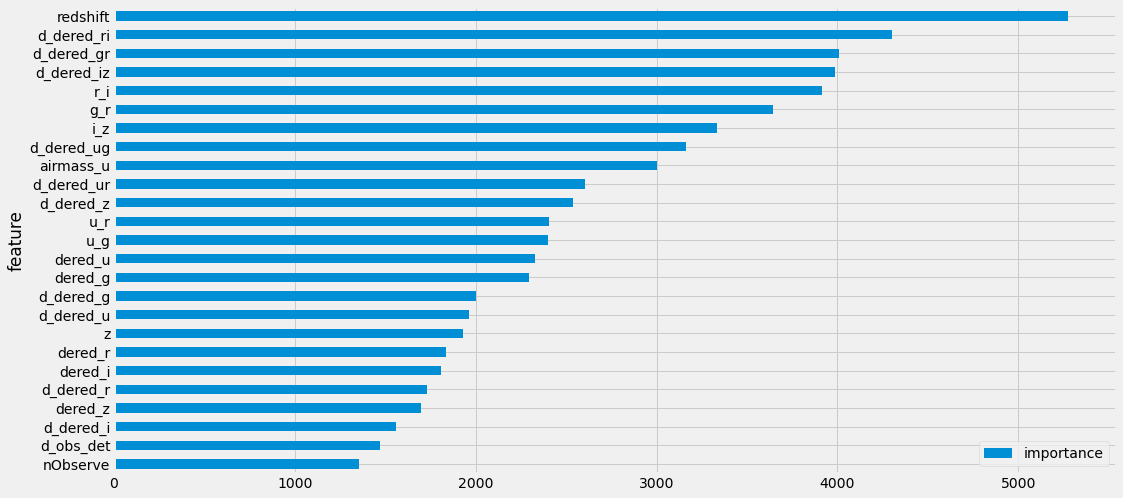

In [36]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [37]:

sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [38]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [39]:

sub[target_col].value_counts()

2    40725
0    29983
1     9292
Name: class, dtype: int64

In [40]:

sub.to_csv(sub_file)